In [81]:
from model import Classifier
from dataLoader import train, test
import torch
from torch.utils.data import Dataset, DataLoader

In [82]:
train.__getitem__(0)[1]

0.0

In [83]:
epochs = 500
batchsize = 128
learning_rate = 1e-4 * 2
weight_Decay = 1e-4


In [84]:
model = Classifier()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_Decay)
print(model)

Classifier(
  (linear1): Linear(in_features=956, out_features=524, bias=True)
  (activation): ReLU()
  (batchNormalization1): BatchNorm1d(524, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=524, out_features=256, bias=True)
  (batchNormalization2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=256, out_features=5, bias=True)
)


In [85]:
train_data = DataLoader(train, batch_size=batchsize, shuffle=True)
test_data = DataLoader(test, batch_size=batchsize, shuffle=True)

In [86]:
model.to(torch.float64)

Classifier(
  (linear1): Linear(in_features=956, out_features=524, bias=True)
  (activation): ReLU()
  (batchNormalization1): BatchNorm1d(524, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=524, out_features=256, bias=True)
  (batchNormalization2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=256, out_features=5, bias=True)
)

In [87]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct ,loss_total = 0, 0
    num_batches = len(dataloader)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        
        y = y.to(torch.long)
        pred = model(X)
        loss = loss_fn(pred, y)
        loss_total += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batchsize + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] ")
    correct/=size
    loss_total/=num_batches
    print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {loss_total:>8f} \n")
    return loss_total, correct*100


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            y = y.to(torch.long)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct*100


train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []
best_accuracy = 0
best_model = model.state_dict()
for t in range(epochs):
    train_data = DataLoader(train, batch_size=batchsize, shuffle=True)
    print(f"Epoch {t+1}\n-------------------------------")
    history, accuracy = train_loop(train_data, model, loss_fn=criterion, optimizer=optimizer)
    train_loss_history.append(history)
    train_accuracy_history.append(accuracy)
    history, accuracy = test_loop(test_data, model, loss_fn=criterion)
    test_loss_history.append(history)
    test_accuracy_history.append(accuracy)
    if accuracy > best_accuracy:
        best_model = model.state_dict()

print(f"Done! Best Accuracy on Test Data Acheived: {accuracy}")


Epoch 1
-------------------------------
loss: 1.727114  [  128/ 3996] 


Train Error: 
 Accuracy: 49.6%, Avg loss: 1.221689 

Test Error: 
 Accuracy: 43.2%, Avg loss: 1.414799 

Epoch 2
-------------------------------
loss: 0.984403  [  128/ 3996] 
Train Error: 
 Accuracy: 59.6%, Avg loss: 1.012263 

Test Error: 
 Accuracy: 47.2%, Avg loss: 1.356444 

Epoch 3
-------------------------------
loss: 0.994044  [  128/ 3996] 
Train Error: 
 Accuracy: 61.7%, Avg loss: 0.946722 

Test Error: 
 Accuracy: 54.5%, Avg loss: 1.095090 

Epoch 4
-------------------------------
loss: 0.895880  [  128/ 3996] 
Train Error: 
 Accuracy: 64.4%, Avg loss: 0.898010 

Test Error: 
 Accuracy: 47.4%, Avg loss: 1.373832 

Epoch 5
-------------------------------
loss: 0.843958  [  128/ 3996] 
Train Error: 
 Accuracy: 65.8%, Avg loss: 0.856634 

Test Error: 
 Accuracy: 51.7%, Avg loss: 1.603798 

Epoch 6
-------------------------------
loss: 0.849559  [  128/ 3996] 
Train Error: 
 Accuracy: 66.3%, Avg loss: 0.858305 

Test Error: 
 Accuracy: 38.4%, Avg loss: 2.703645 

Epoch 7
-------

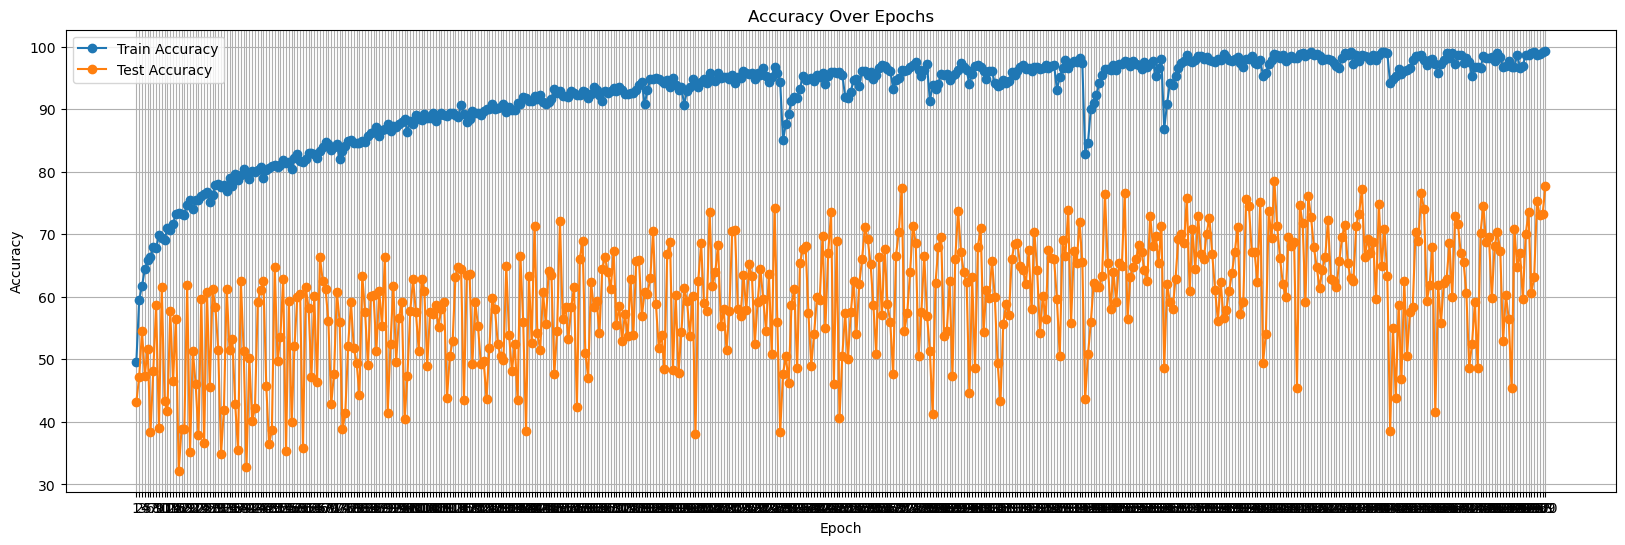

In [88]:
import matplotlib.pyplot as plt

# Create a range of epochs
epoch_range = range(1, epochs + 1)
# Plot accuracy over epochs
plt.figure(figsize=(20,6))
plt.plot(epoch_range, train_accuracy_history, marker='o', linestyle='-', label="Train Accuracy")
plt.plot(epoch_range, test_accuracy_history, marker='o', linestyle='-',  label="Test Accuracy")
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epoch_range)  # Show all epoch values on x-axis
plt.grid(True)
plt.legend()

plt.savefig('Train & Test Accuracy Plot.png')
plt.show()


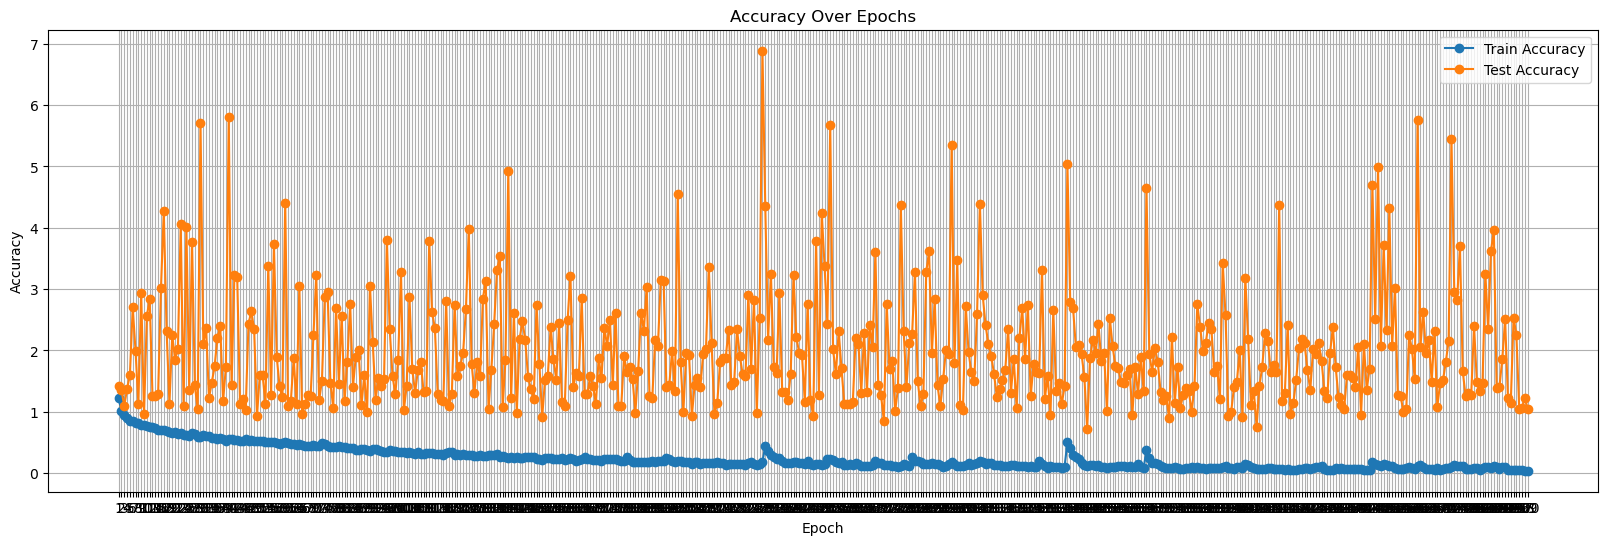

In [89]:
import matplotlib.pyplot as plt

# Create a range of epochs
epoch_range = range(1, epochs + 1)
# Plot accuracy over epochs
plt.figure(figsize=(20,6))
plt.plot(epoch_range, train_loss_history, marker='o', linestyle='-', label="Train Accuracy")
plt.plot(epoch_range, test_loss_history, marker='o', linestyle='-',  label="Test Accuracy")
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epoch_range)  # Show all epoch values on x-axis
plt.grid(True)
plt.legend()

plt.savefig('Train & Test Loss Plot.png')
plt.show()


In [90]:
torch.save(best_model, 'best_model.pth')